<a href="https://colab.research.google.com/github/jigglypop/langchain/blob/master/langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraph Qucikstart 기초예제
## 작성자 : AISchool ( http://aischool.ai/%ec%98%a8%eb%9d%bc%ec%9d%b8-%ea%b0%95%ec%9d%98-%ec%b9%b4%ed%85%8c%ea%b3%a0%eb%a6%ac/ )
## Reference : https://langchain-ai.github.io/langgraph/tutorials/introduction/

# Quick Start

이번 예제는 LangGraph에서 지원 챗봇을 구축하는 종합적인 빠른 시작 가이드입니다.
이 챗봇은 다음과 같은 기능을 가질 것입니다:

*   웹 검색을 통해 일반적인 질문에 답변하기
*   호출 간에 대화 상태를 유지하기

우리는 기본 챗봇으로 시작하여 점진적으로 더 정교한 기능을 추가하면서 LangGraph의 주요 개념을 소개할 것입니다.


# 라이브러리 설치

In [ ]:
!pip install -U langgraph langsmith langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 542.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.9/393.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existi

# API Key 설정

In [ ]:
import os
from uuid import uuid4

unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangGraph Tutorial - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "여러분의_LANGCHAIN_API_KEY"

In [ ]:
unique_id

'be5d09a9'

In [ ]:
os.environ["OPENAI_API_KEY"] = "여러분의_OPENAI_API_KEY"

# Part 1: Build a Basic Chatbot

우리는 먼저 LangGraph를 사용하여 간단한 챗봇을 만들 것입니다. 이 챗봇은 사용자 메시지에 직접 응답합니다. 비록 간단하지만, 이는 **LangGraph를 사용하여 구축하는 핵심 개념을 설명할 것**입니다. 이 섹션이 끝나면 기본적인 챗봇을 구축하게 될 것입니다.

먼저 **StateGraph**를 생성하세요. StateGraph 객체는 "상태 기계"로서 챗봇의 구조를 정의합니다. 우리는 **노드(nodes)**를 추가하여 llm과 챗봇이 호출할 수 있는 기능들을 나타내고, **엣지(edges)**를 추가하여 챗봇이 이러한 기능들 간에 어떻게 전환해야 하는지 지정할 것입니다.

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

**Note** 그래프를 정의할 때 가장 먼저 해야 할 일은 그래프의 상태(State)를 정의하는 것입니다. 상태는 그래프의 스키마와 상태에 대한 업데이트를 적용하는 방법을 지정하는 리듀서(reducer) 함수로 구성됩니다. **우리의 예시에서 상태(State)는 하나의 키를 가진 TypedDict로 정의되며, 이 키는 messages입니다.** messages 키는 **add_messages 리듀서 함수로 주석이 달려 있으며, 이는 LangGraph에게 새로운 메시지를 기존 목록에 추가하도록 지시**하고, 덮어쓰지 않도록 합니다. 주석이 없는 상태 키는 각 업데이트 시 덮어써지며 가장 최근의 값이 저장됩니다. 상태, 리듀서 및 기타 저수준 개념에 대해 더 자세히 알아보려면 이 개념 가이드 ( https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages )를 확인하세요.








이제 우리의 그래프는 두 가지를 알게 되었습니다:


1.   우리가 정의하는 모든 노드는 현재 상태(State)를 입력으로 받아들이고, 그 상태를 업데이트하는 값을 반환합니다.

2.   messages는 직접 덮어써지지 않고 현재 목록에 추가됩니다. 이는 Annotated 구문에서 미리 빌드된 add_messages 함수를 통해 전달됩니다.

다음으로 "chatbot" 노드를 추가합니다. **노드는 작업의 단위를 나타내며, 일반적으로 파이썬 함수로 구현**됩니다.


In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
)

In [ ]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

**챗봇 노드 함수가 현재 상태(State)를 입력으로 받아들이고, "messages"라는 키 아래에 업데이트된 메시지 목록을 포함하는 딕셔너리를 반환하는 방식을 주목**하세요. **이것이 모든 LangGraph 노드 함수의 기본 패턴**입니다.

**상태(State)의 add_messages 함수는 LLM의 응답 메시지를 상태에 이미 존재하는 메시지에 추가**합니다.

다음으로, **진입점(entry point)**을 추가하세요. 이는 **그래프가 매번 실행될 때 어디서 작업을 시작할지 지정**해줍니다.




In [ ]:
graph_builder.add_edge(START, "chatbot")

마찬가지로, **종료 지점(finish point)**을 설정하세요. 이는 그래프에게 **"이 노드가 실행될 때마다, 여기서 종료할 수 있다"**는 지시를 내립니다.

In [ ]:
graph_builder.add_edge("chatbot", END)

마지막으로, 그래프를 실행할 수 있어야 합니다. 이를 위해 **그래프 빌더에서 compile()을 호출**합니다. 이렇게 하면 상태에서 사용할 수 있는 CompiledGraph가 생성됩니다.








In [ ]:
graph = graph_builder.compile()

그래프는 get_graph 메서드와 draw_ascii 또는 draw_png 같은 "draw" 메서드를 사용하여 시각화할 수 있습니다. 각 draw 메서드는 추가적인 종속성을 요구합니다.

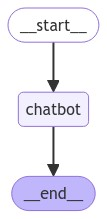

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 챗봇을 실행해 봅시다!

**Tip**: "quit", "exit", 또는 "q"를 입력하면 언제든지 채팅 루프를 종료할 수 있습니다.








In [ ]:
# 테스트 프롬프트 : what's langgraph all about?

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: what's langgraph all about?
Assistant: Langgraph is a language learning platform that uses artificial intelligence and machine learning to help users improve their language skills. It offers personalized lessons, interactive exercises, and real-time feedback to help users practice and improve their speaking, listening, reading, and writing skills in various languages. Langgraph also provides users with language proficiency assessments and progress tracking tools to help them monitor their learning journey.
User: q
Goodbye!


**축하합니다!** LangGraph를 사용하여 첫 번째 챗봇을 성공적으로 구축하셨습니다. 이 봇은 사용자의 입력을 받아 LLM을 사용해 응답을 생성함으로써 기본적인 대화를 할 수 있습니다. 위 호출에 대한 LangSmith 추적을 확인할 수 있습니다.

하지만, **봇의 지식이 그 훈련 데이터에 한정되어 있다는 점**을 눈치채셨을 것입니다. 다음 부분에서는 **웹 검색 도구를 추가하여 봇의 지식을 확장하고, 더 많은 능력을 갖추도록** 만들어 보겠습니다.

아래는 이 섹션의 전체 코드입니다. 참고하시기 바랍니다:








In [ ]:
# from typing import Annotated

# from langchain_anthropic import ChatAnthropic
# from typing_extensions import TypedDict

# from langgraph.graph import StateGraph
# from langgraph.graph.message import add_messages


# class State(TypedDict):
#     messages: Annotated[list, add_messages]


# graph_builder = StateGraph(State)


# llm = ChatAnthropic(model="claude-3-haiku-20240307")


# def chatbot(state: State):
#     return {"messages": [llm.invoke(state["messages"])]}


# # The first argument is the unique node name
# # The second argument is the function or object that will be called whenever
# # the node is used.
# graph_builder.add_node("chatbot", chatbot)
# graph_builder.set_entry_point("chatbot")
# graph_builder.set_finish_point("chatbot")
# graph = graph_builder.compile()

# Part 2: Enhancing the Chatbot with Tools

우리의 챗봇이 **"기억에서" 대답할 수 없는 질문을 처리하기 위해, 웹 검색 도구를 통합할 것**입니다. 이 도구를 사용하면 봇이 관련 정보를 찾아 더 나은 응답을 제공할 수 있습니다.

도구를 정의하세요:

In [ ]:
!pip install -qU duckduckgo-search langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

tool = DuckDuckGoSearchRun()
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

"Step 1: Define the Graph State. First, we define the state structure for our graph. In this example, our state includes the user's question, the classification of the question, and a response ... Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the ... Then, it executes those tools using LangGraph nodes. After execution, a conditional node decides if more planning is required based on the outcome. If so, the loop restarts. If not, the agent ... Combining LangGraph with LangChain agents, agents can be both directed and cyclic. A Directed Acyclic Graph (DAG) is a type of graph used in computer science and mathematics. Here's a simple explanation: Directed: Each connection (or edge) between nodes (or vertices) has a direction, like a one-way street. Nodes (Tasks): Nodes are like the workstations on the assembly line. Each node performs a specific tas

결과는 우리 챗봇이 질문에 답하기 위해 사용할 수 있는 페이지 요약입니다.

다음으로, 그래프를 정의하기 시작하겠습니다. 다음 내용은 **Part 1과 동일하지만, bind_tools를 LLM에 추가**했습니다. 이를 통해 **LLM이 검색 엔진을 사용하려고 할 때 올바른 JSON 형식**을 알 수 있습니다.

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
)
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

다음으로, 도구가 호출될 경우 실제로 실행하는 함수를 만들어야 합니다. 이를 위해 도구들을 새로운 노드에 추가할 것입니다.

아래에서는 **상태에서 가장 최근의 메시지를 확인하고, 메시지에 tool_calls가 포함되어 있으면 도구를 호출하는 BasicToolNode**를 구현합니다. 이 노드는 Anthropic, OpenAI, Google Gemini 등 여러 LLM 제공업체에서 제공하는 LLM의 도구 호출 기능을 사용합니다.

나중에 속도를 높이기 위해 **LangGraph의 미리 빌드된 ToolNode**( https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode )로 이를 대체할 것이지만, 처음에는 직접 구현해 보는 것이 유익합니다.

In [ ]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

도구 노드를 추가한 후, **조건부 엣지(conditional_edges)**를 정의할 수 있습니다.

**엣지(edges)**는 한 노드에서 다음 노드로 제어 흐름을 전달합니다. **조건부 엣지(Conditional edges)**는 일반적으로 **"if" 문을 포함하여 현재 그래프 상태에 따라 다른 노드로 경로를 설정**합니다. 이러한 함수는 현재 그래프 상태를 받아 다음에 호출할 노드의 이름을 나타내는 문자열 또는 문자열 목록을 반환합니다.

아래에서는 **route_tools라는 라우터 함수를 정의**합니다. 이 함수는 **챗봇의 출력에서 tool_calls을 확인**합니다. 이 함수를 그래프에 제공하려면 **add_conditional_edges**를 호출하여, 챗봇 노드가 완료될 때마다 이 함수를 확인해 다음으로 어디로 갈지 결정하도록 그래프에 지시합니다.

조건문은 **tool_calls이 있으면 도구로 라우팅하고, 없으면 "end"로 라우팅**됩니다.

나중에 이를 더 간결하게 하기 위해 미리 빌드된 **tools_condition**( https://langchain-ai.github.io/langgraph/reference/prebuilt/#tools_condition )으로 대체할 것이지만, 처음에 직접 구현해 보면 더 명확해집니다.

In [ ]:
from typing import Literal


def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "__end__" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", "__end__": "__end__"},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**Notice** 조건부 엣지가 단일 노드에서 시작되는 것을 확인하세요. 이는 **그래프에게 "chatbot 노드가 실행될 때마다, 도구를 호출하면 'tools'로 이동하고, 그렇지 않으면 루프를 종료하라"**는 의미를 전달합니다.

미리 빌드된 tools_condition과 마찬가지로, 우리 함수도 도구 호출이 없을 경우 "\_\_end\_\_" 문자열을 반환합니다. 그래프가 "\_\_end\_\_"로 전환되면 더 이상 수행할 작업이 없으므로 실행이 종료됩니다. **조건문이 "\_\_end\_\_"를 반환할 수 있기 때문에, 이번에는 명시적으로 종료 지점(finish_point)을 설정할 필요가 없습니다**. 우리 그래프는 이미 종료할 방법을 가지고 있습니다!

이제 우리가 구축한 그래프를 시각화해 봅시다. 다음 함수는 이 튜토리얼에 중요하지 않은 몇 가지 추가 종속성을 가지고 있습니다.

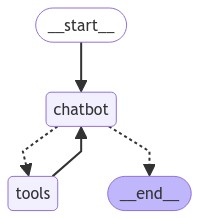

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 봇에게 LLM의 훈련 데이터에 포함되지 않은 질문도 할 수 있습니다.

In [ ]:
# 테스트 프롬프트 : what's langgraph all about?

from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: what's langgraph all about?
Assistant: 
Assistant: "LangGraph is a package for creating LLM workflows with cycles and multi-agent designs. Learn what multi-agent means, why it is useful, and see examples of LangGraph applications and comparisons with other frameworks. LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its ... LangGraph Studio is a desktop app that lets you visualize, interact with, and debug complex agentic applications built with LangGraph, a low-level orchestration framework. Learn how to use it with LangSmith, a platform for creating and managing agents, and see examples of agent graphs and interactions. LangGraph is a framework for building agentic and multi-agent applications with LLMs, and LangGraph Cloud is a scalable and reliable infrastructure for deploying them. Learn how LangGraph helps you design, debug, and monitor

**축하합니다!** 이제 LangGraph에서 **검색 엔진을 사용하여 필요한 경우 최신 정보를 가져올 수 있는 대화형 에이전트**를 만들었습니다. 이제 이 에이전트는 더 다양한 사용자 질문을 처리할 수 있습니다. 에이전트가 방금 수행한 모든 단계를 확인하려면 이 LangSmith 추적을 확인하세요.

하지만 우리의 챗봇은 아직 **과거 상호작용을 기억하지 못해 일관된 멀티턴 대화를 나누는 데 한계**가 있습니다. 다음 부분에서는 이 문제를 해결하기 위해 다음 part에서 **메모리(memory) 기능을 추가**할 것입니다.

이번 섹션에서 만든 그래프의 전체 코드는 아래에 재현되어 있으며, **BasicToolNode를 미리 빌드된 ToolNode로, route_tools 조건을 미리 빌드된 tools_condition으로 대체**했습니다.








In [ ]:
# from typing import Annotated

# from langchain_anthropic import ChatAnthropic
# from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_core.messages import BaseMessage
# from typing_extensions import TypedDict

# from langgraph.graph import StateGraph
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition


# class State(TypedDict):
#     messages: Annotated[list, add_messages]


# graph_builder = StateGraph(State)


# tool = TavilySearchResults(max_results=2)
# tools = [tool]
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm_with_tools = llm.bind_tools(tools)


# def chatbot(state: State):
#     return {"messages": [llm_with_tools.invoke(state["messages"])]}


# graph_builder.add_node("chatbot", chatbot)

# tool_node = ToolNode(tools=[tool])
# graph_builder.add_node("tools", tool_node)

# graph_builder.add_conditional_edges(
#     "chatbot",
#     tools_condition,
# )
# # Any time a tool is called, we return to the chatbot to decide the next step
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.set_entry_point("chatbot")
# graph = graph_builder.compile()

# Part 3: Adding Memory to the Chatbot

우리의 챗봇은 이제 도구를 사용하여 사용자 질문에 답할 수 있지만, **이전 상호작용의 맥락을 기억하지 못합니다.** 이는 일관된 **멀티턴 대화를 나누는 능력을 제한**합니다.

LangGraph는 **지속적인 체크포인팅(persistent checkpointing)**을 통해 이 문제를 해결합니다. **그래프를 컴파일할 때 체크포인터(checkpointer)를 제공**하고 **그래프를 호출할 때 thread_id를 제공**하면, **LangGraph는 각 단계 후 상태를 자동으로 저장**합니다. **동일한 thread_id를 사용하여 그래프를 다시 호출하면, 그래프는 저장된 상태를 로드하여 챗봇이 중단한 지점에서 다시 시작**할 수 있게 됩니다.

**체크포인팅(checkpointing)**이 단순한 채팅 메모리보다 훨씬 강력하다는 것을 나중에 알게 될 것입니다. 이를 통해 오류 복구(error recovery), 인간 개입 워크플로우(human-in-the-loop workflows), 시간 여행 상호작용(time travel interactions) 등 복잡한 상태를 언제든지 저장하고 재개할 수 있습니다. 그러나 너무 앞서 나가기 전에, 먼저 멀티턴 대화를 가능하게 하기 위해 체크포인팅을 추가해 보겠습니다.

시작하려면 **MemorySaver 체크포인터**를 생성하세요.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**Notice** 우리가 **인메모리(in-memory) 체크포인터**를 사용하고 있는 점에 주목하세요. 이는 튜토리얼에서 편리하게 사용되며, **모든 데이터를 메모리에 저장**합니다. **실제 프로덕션 환경에서는 이를 SqliteSaver나 PostgresSaver로 변경하고, 자체 데이터베이스에 연결하여 사용할 가능성**이 큽니다.


다음으로, 그래프를 정의하세요. 이제 직접 만든 BasicToolNode 대신 LangGraph의 미리 빌드된 ToolNode와 tools_condition을 사용할 것입니다. 이들은 병렬 API 실행과 같은 유용한 기능을 제공합니다. 그 외에는 아래 내용이 모두 Part 2에서 복사된 것입니다.

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = DuckDuckGoSearchRun()
tools = [tool]
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

마지막으로, **제공된 체크포인터를 사용하여 그래프를 컴파일**하세요.

In [ ]:
graph = graph_builder.compile(checkpointer=memory)

그래프의 연결성은 Part 2 이후로 변하지 않았다는 점에 주목하세요. 우리가 하는 일은 그래프가 각 노드를 처리할 때 상태(State)를 체크포인팅하는 것뿐입니다.








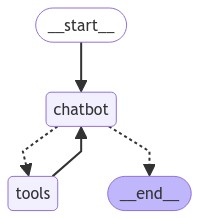

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 봇과 상호작용할 수 있습니다! 먼저, 이 대화에서 사용할 키로 사용할 스레드를 선택하세요.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

다음으로, 챗봇을 호출하세요.

In [ ]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


**Note**: 그래프를 호출할 때 **설정(config)은 두 번째 위치 인자로 제공**되었습니다. 중요한 점은 설정이 그래프 입력({messages: []}) 내에 중첩되지 않는다는 것입니다.

이제 후속 질문을 해봅시다: 챗봇이 당신의 이름을 기억하는지 확인해보세요.








In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name, Will. How can I help you today?


우리가 외부 목록을 사용하여 메모리를 관리하지 않는다는 점에 주목하세요. **모든 것이 체크포인터에 의해 처리**됩니다! 이 LangSmith 추적에서 전체 실행 과정을 확인하여 어떻게 작동하는지 살펴볼 수 있습니다.

믿기 어렵나요? **다른 설정(config)을 사용하여 시도**해 보세요.








In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Of course, I remember your name! You are [User's Name]. How can I assist you today?


**Notice** 우리가 한 유일한 변경 사항은 설정(config)에서 thread_id를 수정한 것입니다. 이 호출의 LangSmith 추적을 비교해 보세요.

이제 두 개의 다른 스레드에 걸쳐 몇 가지 체크포인트를 만들었습니다. 하지만 체크포인트에는 무엇이 들어갈까요? **주어진 설정(config)에 대한 그래프의 상태를 언제든지 확인하려면 get_state(config)를 호출**하세요.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', id='51bb4d61-6fd9-4eb6-9b4d-e81b03a59e12'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 84, 'total_tokens': 95}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-d48d0ad9-321e-45a2-9130-5a998ab000a8-0', usage_metadata={'input_tokens': 84, 'output_tokens': 11, 'total_tokens': 95}), HumanMessage(content='Remember my name?', id='7bac623e-d894-46eb-8870-d9e8e6e218e1'), AIMessage(content='Yes, I remember your name, Will. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 106, 'total_tokens': 123}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-e4f33b44-17

In [ ]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

위 스냅샷에는 **현재 상태 값, 해당 설정(config), 그리고 처리할 다음 노드**가 포함되어 있습니다. 우리의 경우, 그래프가 __end__ 상태에 도달했기 때문에 next는 비어 있습니다.

**축하합니다!** 이제 챗봇이 LangGraph의 **체크포인팅 시스템 덕분에 세션 간에 대화 상태를 유지**할 수 있게 되었습니다. 이를 통해 **보다 자연스럽고 맥락적인 상호작용이 가능**해졌습니다. LangGraph의 체크포인팅은 **임의로 복잡한 그래프 상태도 처리할 수 있어, 단순한 채팅 메모리보다 훨씬 표현력 있고 강력**합니다.

아래 코드 스니펫을 확인하여 이번 섹션에서 만든 그래프를 복습해 보세요.








In [ ]:
# from typing import Annotated

# from langchain_anthropic import ChatAnthropic
# from langchain_community.tools.tavily_search import TavilySearchResults
# from langchain_core.messages import BaseMessage
# from typing_extensions import TypedDict

# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph import StateGraph
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode


# class State(TypedDict):
#     messages: Annotated[list, add_messages]


# graph_builder = StateGraph(State)


# tool = TavilySearchResults(max_results=2)
# tools = [tool]
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
# llm_with_tools = llm.bind_tools(tools)


# def chatbot(state: State):
#     return {"messages": [llm_with_tools.invoke(state["messages"])]}


# graph_builder.add_node("chatbot", chatbot)

# tool_node = ToolNode(tools=[tool])
# graph_builder.add_node("tools", tool_node)

# graph_builder.add_conditional_edges(
#     "chatbot",
#     tools_condition,
# )
# graph_builder.add_edge("tools", "chatbot")
# graph_builder.set_entry_point("chatbot")
# graph = graph_builder.compile(checkpointer=memory)